# Analyse data from the influx experiment

The question is: what kind of influx of TRM do we expect after the peak of the immune response / infection.
We use data from a congenic mouse experiment to get some insights.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
from matplotlib.gridspec import GridSpec
import json
import cmdstanpy


tex_fonts = {
    "font.family" : "Helvetica",
    'pdf.fonttype' : 42,
}

plt.rcParams.update(tex_fonts)

spline_color = 'k'
spline_lw = 0.7
spline_dash = (0, (10,10))
default_spline_kwargs = {
    "linewidth" : spline_lw, "color" : spline_color, "zorder" : 1
}

labx, laby = -0.2, 1.05

## We use a simple Stan model to fit the linear regressions

This Stan model is included in the `scdynsys` package.

In [2]:
sm = cmdstanpy.CmdStanModel(stan_file="../scdynsys/stan_models/linreg.stan")

## Import the data from the tranfer experiment

The required data is saved in a simple JSON file.

In [3]:

import json
with open("../data/transfer_expt_data.json", "r") as f:
    data = json.load(f)

total_lung_CD8 = np.array(data["total_lung_CD8"])
donor_lung_CD8 = np.array(data["donor_lung_CD8"])
total_circ_CD8 = np.array(data["total_circ_CD8"])
donor_circ_CD8 = np.array(data["donor_circ_CD8"])

total_lung_CD4 = np.array(data["total_lung_CD4"])
donor_lung_CD4 = np.array(data["donor_lung_CD4"])
total_circ_CD4 = np.array(data["total_circ_CD4"])
donor_circ_CD4 = np.array(data["donor_circ_CD4"])

time = np.array(data["time"])

time_rep = np.array(data["time_rep"])

## counts in gates

nDR8 = np.array(data["nDR8"], dtype='int')
nDC8 = np.array(data["nDC8"], dtype='int')
nHC8 = np.array(data["nHC8"], dtype='int')
nHR8 = np.array(data["nHR8"], dtype='int')
nDR4 = np.array(data["nDR4"], dtype='int')
nDC4 = np.array(data["nDC4"], dtype='int')
nHC4 = np.array(data["nHC4"], dtype='int')
nHR4 = np.array(data["nHR4"], dtype='int')


### Plot the imported data

To give an indication how precise the measurements are, we also plot the fraction of cells in the gates, and show confidence intervals based on the binomial distribution.

The dataset contains fields `nXYZ` where `X` is `D` for donor or `H` for host; `Y` is `R` for resident of `C` for circulating (based on i.v. label) and `Z` is `4` for CD4 and `8` for CD8.

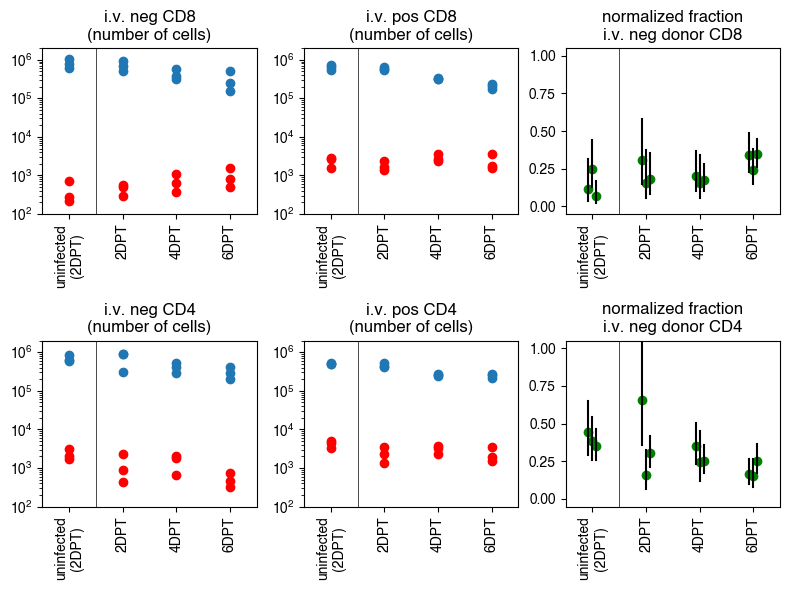

In [4]:
fig, axs = plt.subplots(2, 3, figsize=(8, 6))

axs[0,0].scatter(time_rep, total_lung_CD8)
axs[0,0].scatter(time_rep, donor_lung_CD8, color='r')

axs[0,1].scatter(time_rep, total_circ_CD8)
axs[0,1].scatter(time_rep, donor_circ_CD8, color='r')

axs[1,0].scatter(time_rep, total_lung_CD4)
axs[1,0].scatter(time_rep, donor_lung_CD4, color='r')

axs[1,1].scatter(time_rep, total_circ_CD4)
axs[1,1].scatter(time_rep, donor_circ_CD4, color='r')


for ax in axs[:,:2].flatten():
    ax.set_yscale('log')
    ax.set_ylim(1e2, 2e6)    

# use offsets to avoid overlap of CIs

offsets = np.tile([-0.15, 0, 0.15], 4)

axs[0,2].scatter(time_rep + offsets, (nDR8 / (nDR8 + nHR8)) / (nDC8 / (nDC8 + nHC8)), color='g')
axs[0,2].set_title("relative fraction resident donor cells CD8")

axs[1,2].scatter(time_rep + offsets, (nDR4 / (nDR4 + nHR4)) / (nDC4 / (nDC4 + nHC4)), color='g')
axs[0,2].set_title("relative fraction resident donor cells CD4")

CIs_CD8 = sts.beta.interval(a=nDR8+0.5, b=nHR8+0.5, confidence=0.95)
CIs_CD4 = sts.beta.interval(a=nDR4+0.5, b=nHR4+0.5, confidence=0.95)

for i, (l, b) in enumerate(zip(*CIs_CD8)):
    s = nDC8[i] / (nDC8[i] + nHC8[i])
    t = time_rep[i] + offsets[i]
    axs[0,2].plot([t, t], [l/s, b/s], color='k')

for i, (l, b) in enumerate(zip(*CIs_CD4)):
    s = nDC4[i] / (nDC4[i] + nHC4[i])
    t = time_rep[i] + offsets[i]
    axs[1,2].plot([t, t], [l/s, b/s], color='k')


for ax in axs[:,2]:
    ax.set_ylim(-0.05, 1.05)

lineages = ["CD8", "CD4"]

for i, lin in enumerate(lineages):
    axs[i,0].set_title(f"i.v. neg {lin}\n(number of cells)")
    axs[i,1].set_title(f"i.v. pos {lin}\n(number of cells)")
    axs[i,2].set_title(f"normalized fraction\ni.v. neg donor {lin}")

for ax in axs.flatten():
    ax.set_xticks(time)
    ax.set_xticklabels(["uninfected\n(2DPT)", "2DPT", "4DPT", "6DPT"], rotation=90)
    ax.axvline(1, color='k', linewidth=0.5)
    ax.set_xlim(-1, 7)


fig.tight_layout()

## Fit the Stan model to the datasets

First define some helper functions for fitting and plotting the data

In [5]:
def fit_stan_model_abs(xs):
    that = np.linspace(1, 7, 100)

    data = {"N" : len(xs[3:]), "x" : time_rep[3:]-4, "y" : np.log(xs[3:]), "Nhat" : len(that), "xhat" : that-4}
    sam = sm.sample(data=data, iter_sampling=10000, show_progress=False)

    return data, sam, that


def plot_stan_fit_abs(ax, xs, sam, that, ID, scale=1.0):
    bhat = sam.stan_variable("b")
    imap = sam.stan_variable("loglik").argmax()
    amap, bmap = sam.stan_variable("a")[imap], sam.stan_variable("b")[imap]
    print(f"rate {ID}", bmap, np.percentile(bhat, q=[2.5, 97.5]))
    bstd = np.std(bhat)
    ax.text(0.95, 0.95, f"$\\lambda = {-bmap:0.2f} \pm {bstd:0.2f}\, d^{{-1}}$", transform=ax.transAxes, 
            va='top', ha='right', fontsize='small')

    ax.scatter(time_rep, xs * scale, color='k', zorder=2)
    xlb, xub = np.percentile(sam.stan_variable("yhat"), axis=0, q=[2.5, 97.5])
    xmap = sam.stan_variable("yhat")[imap]
    ax.plot(that, np.exp(xlb) * scale, linestyle='--', **default_spline_kwargs)
    ax.plot(that, np.exp(xub) * scale, linestyle='--', **default_spline_kwargs)
    ax.plot(that, np.exp(xmap) * scale, **default_spline_kwargs)

    ax.set_xticks(time)
    ax.set_xticklabels(["uninfected\n(2DPT)", "2DPT", "4DPT", "6DPT"], rotation=90)
    ax.axvline(1, color='k', linewidth=0.5)


### Fit the model to the data using the above function

In [6]:
dataR8, samR8, thatR8 = fit_stan_model_abs(total_lung_CD8)
dataRD8, samRD8, thatR8 = fit_stan_model_abs(donor_lung_CD8)

dataC8, samC8, thatC8 = fit_stan_model_abs(total_circ_CD8)
dataCD8, samCD8, thatC8 = fit_stan_model_abs(donor_circ_CD8)

dataR4, samR4, thatR4 = fit_stan_model_abs(total_lung_CD4)
dataRD4, samRD4, thatR4 = fit_stan_model_abs(donor_lung_CD4)

dataC4, samC4, thatC4 = fit_stan_model_abs(total_circ_CD4)
dataCD4, samCD4, thatC4 = fit_stan_model_abs(donor_circ_CD4)


17:28:52 - cmdstanpy - INFO - CmdStan start processing
17:28:52 - cmdstanpy - INFO - Chain [1] start processing
17:28:52 - cmdstanpy - INFO - Chain [2] start processing
17:28:52 - cmdstanpy - INFO - Chain [3] start processing
17:28:52 - cmdstanpy - INFO - Chain [4] start processing
17:28:53 - cmdstanpy - INFO - Chain [2] done processing
17:28:53 - cmdstanpy - INFO - Chain [4] done processing
17:28:53 - cmdstanpy - INFO - Chain [3] done processing
17:28:53 - cmdstanpy - INFO - Chain [1] done processing
17:28:54 - cmdstanpy - INFO - CmdStan start processing
17:28:54 - cmdstanpy - INFO - Chain [1] start processing
17:28:54 - cmdstanpy - INFO - Chain [2] start processing
17:28:54 - cmdstanpy - INFO - Chain [3] start processing
17:28:54 - cmdstanpy - INFO - Chain [4] start processing
17:28:54 - cmdstanpy - INFO - Chain [2] done processing
17:28:54 - cmdstanpy - INFO - Chain [3] done processing
17:28:54 - cmdstanpy - INFO - Chain [4] done processing
17:28:54 - cmdstanpy - INFO - Chain [1] do

## Figure of transfer experiment

Figure showing the logic and results of the transfer experiment.

* A diagram showing the experiment
* Panels showing the number of T cells as a function of time post transfer and calculated stats

In [7]:
fig = plt.figure(figsize=(14,5))
gs = GridSpec(4, 11)

fig.subplots_adjust(wspace=0.2, hspace=0.4)

<Figure size 1400x500 with 0 Axes>

### Make an experiment diagram

In [8]:
## import mouse cartoon

mouse_im = plt.imread('../resources/mouse_cartoon.png')
lungs_im = plt.imread('../resources/lungs_cartoon.png')
ln_im = plt.imread('../resources/lymph_node_cartoon.png')
spleen_im = plt.imread('../resources/spleen_cartoon.png')


imagebox_mouse1 = OffsetImage(mouse_im, zoom = 0.05)
imagebox_mouse2 = OffsetImage(mouse_im, zoom = 0.04)

imagebox_lungs1 = OffsetImage(lungs_im, zoom = 0.025)
imagebox_lungs2 = OffsetImage(lungs_im, zoom = 0.02)

imagebox_ln1 = OffsetImage(ln_im, zoom = 0.035)
imagebox_spleen1 = OffsetImage(spleen_im, zoom = 0.035)


# cartoon for transfer experiment

ax = fig.add_subplot(gs[:3, 0:2])

sampling_times = [16, 18, 20]
ypos = [3,2,1]

for i, t in enumerate(sampling_times):
    ax.plot([0,t], [ypos[i],ypos[i]], color='k', marker='o')

ax.plot([0, 14], [8, 8], color='k', marker='o')


ax.set_ylim(0, 10)
ax.set_yticks([])

annbox_mouse1 = AnnotationBbox(imagebox_mouse2, (0.1, 0.9), frameon=False, xycoords='axes fraction', zorder=1)
annbox_mouse2 = AnnotationBbox(imagebox_mouse2, (0.1, 0.4), frameon=False, xycoords='axes fraction', zorder=1)
annbox_lungs1 = AnnotationBbox(imagebox_lungs1, (0.9, 0.4), frameon=False, xycoords='axes fraction', zorder=1)
annbox_ln1 = AnnotationBbox(imagebox_ln1, (0.9, 0.9), frameon=False, xycoords='axes fraction', zorder=1)
annbox_spleen1 = AnnotationBbox(imagebox_spleen1, (0.6, 0.9), frameon=False, xycoords='axes fraction', zorder=1)


ax.add_artist(annbox_mouse1)
ax.annotate(
    "CD90.1", xy=(0.15, 0.9), xycoords='axes fraction', 
    color='w', zorder=2, va='center', ha='center',
    fontsize='small'
)

ax.add_artist(annbox_lungs1)

ax.add_artist(annbox_ln1)
ax.add_artist(annbox_spleen1)

ax.add_artist(annbox_mouse2)
ax.annotate(
    "CD90.2", xy=(0.15, 0.4), xycoords='axes fraction', 
    color='w', zorder=2, va='center', ha='center',
    fontsize='small'
)

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.left.set_visible(False)


ax.set_xticks([0, 14, 16, 18, 20])

# draw some arrows

props = dict(boxstyle='round', facecolor='w')

ax.text(14, 6, "transfer", color='k', ha='center', va='center', bbox=props, zorder=2)

aprops = arrowprops=dict(
    facecolor='black', 
    arrowstyle='->',
    lw=1,
    shrinkB=5
)

## arrows for transfer
ax.annotate(
    '', xy=(14, 3), transform=ax.transData,
    xytext=(14, 8), va='bottom', ha='center', zorder=1,
    arrowprops=aprops
)

ax.text(0, 6, "IAV infection", color='k', ha='center', va='center', bbox=props, zorder=2)

## arrows for infection
ax.annotate(
    '', xy=(0, 8), transform=ax.transData,
    xytext=(0, 6), va='center', ha='center', zorder=1,
    arrowprops=aprops
)

ax.annotate(
    '', xy=(0, 4.5), transform=ax.transData,
    xytext=(0, 6), va='center', ha='center', zorder=1,
    arrowprops=aprops
)

ax.set_xlabel("DPI")

Ax = fig.add_subplot(gs[:2, 0:2])
Ax.axis('off')
Ax.text(labx, laby, 'A', fontsize='xx-large', transform=Ax.transAxes)


Text(-0.2, 1.05, 'A')

### Make plots of the data and regression model fits

In [9]:
axs = [[None for _ in range(2)] for _ in range(4)]
for j in range(2):
    ax = None
    for i in range(4):
        ax = fig.add_subplot(gs[2*j:2*(j+1), 2*i+3:2*(i+1)+3], sharex=ax, sharey=ax)
        axs[i][j] = ax

axs = np.array(axs).T

plot_scale = 0.000001

plot_stan_fit_abs(axs[0,0], total_lung_CD8, samR8, thatR8, "host + donor CD8 (lung)", scale=plot_scale)
plot_stan_fit_abs(axs[1,0], donor_lung_CD8, samRD8, thatR8, "donor CD8 (lung)")

plot_stan_fit_abs(axs[0,1], total_circ_CD8, samC8, thatC8, "host + donor CD8 (circ)", scale=plot_scale)
plot_stan_fit_abs(axs[1,1], donor_circ_CD8, samCD8, thatC8, "donor CD8 (circ)")

plot_stan_fit_abs(axs[0,2], total_lung_CD4, samR4, thatR4, "host + donor CD4 (lung)", scale=plot_scale)
plot_stan_fit_abs(axs[1,2], donor_lung_CD4, samRD4, thatR4, "donor CD4 (lung)")

plot_stan_fit_abs(axs[0,3], total_circ_CD4, samC4, thatC4, "host + donor CD4 (circ)", scale=plot_scale)
plot_stan_fit_abs(axs[1,3], donor_circ_CD4, samCD4, thatC4, "donor CD4 (circ)")



axs[0,0].set_ylabel("total (host + donor) $\\times 10^6$")
axs[1,0].set_ylabel("donor")

axs[0,0].set_title("CD8 (lung)")
axs[0,1].set_title("CD8 (circulation)")
axs[0,2].set_title("CD4 (lung) ")
axs[0,3].set_title("CD4 (circulation) ")

axs[0,0].set_ylim(0, 1.3)
axs[1,0].set_ylim(0, 6000)
axs[0,0].set_xlim(-1, 7)
axs[1,0].set_xlim(-1, 7)


for ax in axs[:,1:].flat:
    plt.setp(ax.get_yticklabels(which="both"), visible=False)

for ax in axs[0,:].flat:
    plt.setp(ax.get_xticklabels(which="both"), visible=False)


Ax = fig.add_subplot(gs[:2, 3:5])
Ax.axis('off')
Ax.text(labx, laby, 'B', fontsize='xx-large', transform=Ax.transAxes)


fig.align_ylabels()


rate host + donor CD8 (lung) -0.237126 [-0.45554682 -0.02143455]
rate donor CD8 (lung) 0.16881 [-0.08791594  0.42588248]
rate host + donor CD8 (circ) -0.259595 [-0.31354807 -0.20679972]
rate donor CD8 (circ) 0.0452648 [-0.14620977  0.24171408]
rate host + donor CD4 (lung) -0.191154 [-0.41205923  0.03873231]
rate donor CD4 (lung) -0.167416 [-0.55562275  0.213915  ]
rate host + donor CD4 (circ) -0.155289 [-0.25617123 -0.05493991]
rate donor CD4 (circ) -0.0101437 [-0.22553023  0.21470453]


### Show the figure

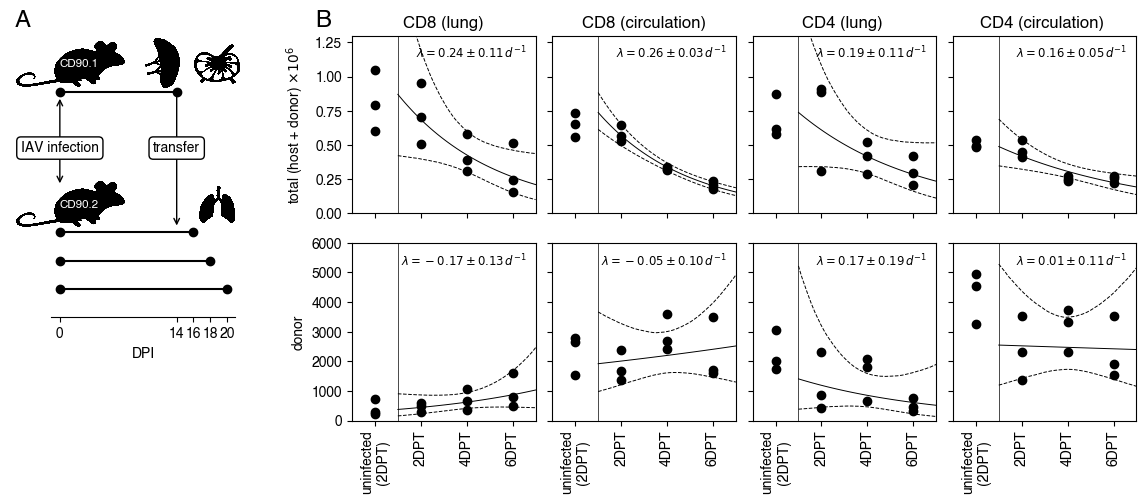

In [10]:
fig

In [11]:
#fig.savefig("../results/FigureTransferExpt.pdf", bbox_inches='tight')

## Compute some stats

To be used in the SI text

In [12]:
print("donor CD8", sts.ttest_1samp(donor_circ_CD8 / donor_lung_CD8, 1))
print("donor CD4", sts.ttest_1samp(donor_circ_CD4 / donor_lung_CD4, 1))

print("total CD8", sts.ttest_1samp(total_circ_CD8 / total_lung_CD8, 1))
print("total CD4", sts.ttest_1samp(total_circ_CD4 / total_lung_CD4, 1))

print("donor CD8 ratio", np.mean(donor_circ_CD8 / donor_lung_CD8))
print("donor CD4 ratio", np.mean(donor_circ_CD4 / donor_lung_CD4))

donor CD8 TtestResult(statistic=5.519552055289806, pvalue=0.00018083761385230817, df=11)
donor CD4 TtestResult(statistic=3.629388730339432, pvalue=0.003960879635852171, df=11)
total CD8 TtestResult(statistic=-1.6528338749298392, pvalue=0.1265915223739981, df=11)
total CD4 TtestResult(statistic=-1.7873716422148913, pvalue=0.10142883274065763, df=11)
donor CD8 ratio 4.651682617491441
donor CD4 ratio 2.994046210414748
